In [348]:
import sys
sys.path.insert(0, '..')

In [349]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)

from sklearn.decomposition import PCA

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [350]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [351]:
wid = 64
oversample = 4

nwavels = 3
npoly=1

n_zernikes = 12-1#12-1

optics = NICMOSFresnelOptics(512, wid, oversample, defocus =0., n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2025-06-20T23_47_51.088Z/HST/"


files = """
na2ma5mrq_cal.fits
na2ma5msq_cal.fits
na2ma5mtq_cal.fits
na2ma5muq_cal.fits
na2ma5mvq_cal.fits
na2ma5mwq_cal.fits
na2ma5mxq_cal.fits
na2ma5myq_cal.fits
na2ma5mzq_cal.fits
na2ma5n1q_cal.fits
na2ma5n2q_cal.fits
na2ma5n3q_cal.fits
na2ma5n4q_cal.fits
na2ma5n5q_cal.fits
na2ma5n6q_cal.fits
na2ma5n7q_cal.fits
na2ma5n8q_cal.fits
na2ma5n9q_cal.fits
na2ma5nbq_cal.fits
na2ma5ncq_cal.fits
na2ma5ndq_cal.fits
na2ma5neq_cal.fits
na2ma5nfq_cal.fits
na2ma5ngq_cal.fits
na2ma5nhq_cal.fits
na2ma5niq_cal.fits
na2ma5njq_cal.fits
na2ma5nkq_cal.fits
na2ma5nmq_cal.fits
na2ma5nnq_cal.fits
na2ma5noq_cal.fits
na2ma5npq_cal.fits
na2ma5nqq_cal.fits
na2ma5nrq_cal.fits
na2ma5nsq_cal.fits
na2ma5ntq_cal.fits
na2ma5nuq_cal.fits
na2ma5nwq_cal.fits
na2ma5nxq_cal.fits
na2ma5nyq_cal.fits
na2ma5nzq_cal.fits
na2ma5o0q_cal.fits
na2ma5o1q_cal.fits
na2ma5o2q_cal.fits
na2ma5o3q_cal.fits
na2ma5o4q_cal.fits
na2ma5o5q_cal.fits
na2ma5o7q_cal.fits
na2ma5o8q_cal.fits
na2ma5o9q_cal.fits
na2ma5oaq_cal.fits
na2ma5obq_cal.fits
na2ma5ocq_cal.fits
na2ma5odq_cal.fits
na2ma5oeq_cal.fits
na2ma5ofq_cal.fits
na2ma5ohq_cal.fits
na2ma5oiq_cal.fits
na2ma5ojq_cal.fits
na2ma5okq_cal.fits
na2ma5olq_cal.fits
na2ma5omq_cal.fits
na2ma5onq_cal.fits
na2ma5ooq_cal.fits
na2ma5opq_cal.fits
na2ma5oqq_cal.fits
na2ma5osq_cal.fits
na2ma5otq_cal.fits
na2ma5ouq_cal.fits
na2ma5ovq_cal.fits
na2ma5owq_cal.fits
na2ma5oxq_cal.fits
na2ma5oyq_cal.fits
na2ma5ozq_cal.fits
na2ma5p0q_cal.fits
na2ma5p2q_cal.fits
na2ma5p3q_cal.fits
na2ma5p4q_cal.fits
na2ma5p5q_cal.fits
na2ma5p6q_cal.fits
na2ma5p7q_cal.fits
na2ma5p8q_cal.fits
na2ma5p9q_cal.fits
na2ma5paq_cal.fits
na2ma5pbq_cal.fits
na2ma5pdq_cal.fits
na2ma5peq_cal.fits
na2ma5pfq_cal.fits
na2ma5pgq_cal.fits
na2ma5phq_cal.fits
na2ma5piq_cal.fits
na2ma5pjq_cal.fits
na2ma5pkq_cal.fits
na2ma5plq_cal.fits
na2ma5pnq_cal.fits
na2ma5poq_cal.fits
na2ma5ppq_cal.fits
na2ma5pqq_cal.fits
na2ma5prq_cal.fits
na2ma5psq_cal.fits
na2ma5ptq_cal.fits
na2ma5puq_cal.fits
na2ma5pvq_cal.fits
na2ma5pwq_cal.fits
na2ma5pyq_cal.fits
na2ma5pzq_cal.fits
na2ma5q0q_cal.fits
na2ma5q1q_cal.fits
na2ma5q2q_cal.fits
na2ma5q3q_cal.fits
na2ma5q4q_cal.fits
na2ma5q5q_cal.fits
na2ma5q6q_cal.fits
na2ma5q8q_cal.fits
na2ma5q9q_cal.fits
na2ma5qaq_cal.fits
na2ma5qbq_cal.fits
na2ma5qcq_cal.fits
na2ma5qdq_cal.fits
na2ma5qeq_cal.fits
na2ma5qfq_cal.fits
na2ma5qgq_cal.fits
na2ma5qhq_cal.fits
na2ma5qjq_cal.fits
na2ma5qkq_cal.fits
na2ma5qlq_cal.fits
na2ma5qmq_cal.fits
na2ma5qnq_cal.fits
na2ma5qoq_cal.fits
na2ma5qpq_cal.fits
na2ma5qqq_cal.fits
na2ma5qrq_cal.fits
na2ma5qtq_cal.fits
na2ma5quq_cal.fits
na2ma5qvq_cal.fits
na2ma5qwq_cal.fits
na2ma5qxq_cal.fits
na2ma5qyq_cal.fits
na2ma5qzq_cal.fits
na2ma5r0q_cal.fits
na2ma5r1q_cal.fits
na2ma5r2q_cal.fits
na2ma5r4q_cal.fits
na2ma5r5q_cal.fits
na2ma5r6q_cal.fits
na2ma5r7q_cal.fits
na2ma5r8q_cal.fits
na2ma5r9q_cal.fits
na2ma5raq_cal.fits
na2ma5rbq_cal.fits
na2ma5rcq_cal.fits
na2ma5req_cal.fits
na2ma5rfq_cal.fits
na2ma5rgq_cal.fits
na2ma5rhq_cal.fits
na2ma5riq_cal.fits
na2ma5rjq_cal.fits
na2ma5rkq_cal.fits
na2ma5rlq_cal.fits
na2ma5rmq_cal.fits
na2ma5rnq_cal.fits
na2ma5rpq_cal.fits
na2ma5rqq_cal.fits
na2ma5rrq_cal.fits
na2ma5rsq_cal.fits
na2ma5rtq_cal.fits
na2ma5ruq_cal.fits
na2ma5rvq_cal.fits
na2ma5rwq_cal.fits
na2ma5rxq_cal.fits
na2ma5rzq_cal.fits
na2ma5s0q_cal.fits
na2ma5s1q_cal.fits
na2ma5s2q_cal.fits
na2ma5s3q_cal.fits
na2ma5s4q_cal.fits
na2ma5s5q_cal.fits
na2ma5s6q_cal.fits
na2ma5s7q_cal.fits
na2ma5s8q_cal.fits
na2ma5saq_cal.fits
na2ma5sbq_cal.fits
na2ma5scq_cal.fits
na2ma5sdq_cal.fits
na2ma5seq_cal.fits
na2ma5sfq_cal.fits
na2ma5sgq_cal.fits
na2ma5shq_cal.fits
na2ma5siq_cal.fits
na2ma5skq_cal.fits
na2ma5slq_cal.fits
na2ma5smq_cal.fits
na2ma5snq_cal.fits
na2ma5soq_cal.fits
na2ma5spq_cal.fits
na2ma5sqq_cal.fits
na2ma5srq_cal.fits
na2ma5ssq_cal.fits
na2ma5stq_cal.fits
na2ma5svq_cal.fits
na2ma5swq_cal.fits
na2ma5sxq_cal.fits
na2ma5syq_cal.fits
na2ma5szq_cal.fits
na2ma5t0q_cal.fits
na2ma5t1q_cal.fits
na2ma5t2q_cal.fits
na2ma5t3q_cal.fits
na2ma5t5q_cal.fits
na2ma5t6q_cal.fits
na2ma5t7q_cal.fits
na2ma5t8q_cal.fits
na2ma5t9q_cal.fits
na2ma5taq_cal.fits
na2ma5tbq_cal.fits
na2ma5tcq_cal.fits
na2ma5tdq_cal.fits
na2ma5teq_cal.fits
na2ma5tfq_cal.fits
na2ma5tgq_cal.fits""".split()[::10]

exposures_raw = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

exposures_single = []
for exp in exposures_raw:
    if exp.data.shape == (wid, wid):
        exposures_single.append(exp)

#exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

In [352]:
data = '../data/MAST_2024-09-27T00_15_31.056Z/HST/'

files = """
na2a12jmq_cal.fits
na2a12jnq_cal.fits
na2a12joq_cal.fits
na2a12jpq_cal.fits
na2a12jqq_cal.fits
na2a12jxq_cal.fits
na2a12jzq_cal.fits
na2a12k0q_cal.fits
na2a12k1q_cal.fits
na2a12k2q_cal.fits
na2a12k9q_cal.fits
na2a12kbq_cal.fits
na2a12kcq_cal.fits
na2a12kdq_cal.fits
na2a12keq_cal.fits
na2a12klq_cal.fits
na2a12knq_cal.fits
na2a12koq_cal.fits
na2a12kpq_cal.fits
na2a12kqq_cal.fits
na2a12kxq_cal.fits
na2a12kzq_cal.fits
na2a12l0q_cal.fits
na2a12l1q_cal.fits
na2a12l2q_cal.fits
na2a12lgq_cal.fits
na2a12liq_cal.fits
na2a12ljq_cal.fits
na2a12lkq_cal.fits
na2a12llq_cal.fits
na2a12lsq_cal.fits
na2a12luq_cal.fits
na2a12lvq_cal.fits
na2a12lwq_cal.fits
na2a12lxq_cal.fits
na2a12m4q_cal.fits
na2a12m6q_cal.fits
na2a12m7q_cal.fits
na2a12m8q_cal.fits
na2a12m9q_cal.fits
na2a12mgq_cal.fits
na2a12miq_cal.fits
na2a12mjq_cal.fits
na2a12mkq_cal.fits
na2a12mlq_cal.fits
na2a12msq_cal.fits
na2a12muq_cal.fits
na2a12mvq_cal.fits
na2a12mwq_cal.fits
na2a12mxq_cal.fits
na2a12n4q_cal.fits
na2a12n6q_cal.fits
na2a12n7q_cal.fits
na2a12n8q_cal.fits
na2a12n9q_cal.fits
""".split()[::3]

print(files)


#exposures_raw = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files]#[:10]
#exposures_single = []
#for exp in exposures_raw:
#    if exp.data.shape == (wid, wid):
#        exposures_single.append(exp)


['na2a12jmq_cal.fits', 'na2a12jpq_cal.fits', 'na2a12jzq_cal.fits', 'na2a12k2q_cal.fits', 'na2a12kcq_cal.fits', 'na2a12klq_cal.fits', 'na2a12kpq_cal.fits', 'na2a12kzq_cal.fits', 'na2a12l2q_cal.fits', 'na2a12ljq_cal.fits', 'na2a12lsq_cal.fits', 'na2a12lwq_cal.fits', 'na2a12m6q_cal.fits', 'na2a12m9q_cal.fits', 'na2a12mjq_cal.fits', 'na2a12msq_cal.fits', 'na2a12mwq_cal.fits', 'na2a12n6q_cal.fits', 'na2a12n9q_cal.fits']


In [353]:
data = '../data/MAST_2025-06-26T06_57_47.174Z/HST/'

files = """
na2m01k7q_cal.fits
na2m01k8q_cal.fits
na2m01k9q_cal.fits
na2m01kaq_cal.fits
na2m01kbq_cal.fits
na2m01kcq_cal.fits
na2m01kdq_cal.fits
na2m01keq_cal.fits
na2m01kfq_cal.fits
na2m01kgq_cal.fits
na2m01kiq_cal.fits
na2m01kjq_cal.fits
na2m01kkq_cal.fits
na2m01klq_cal.fits
na2m01kmq_cal.fits
na2m01knq_cal.fits
na2m01koq_cal.fits
na2m01kpq_cal.fits
na2m01kqq_cal.fits
na2m01krq_cal.fits
na2m01ksq_cal.fits
na2m01ktq_cal.fits
na2m01kuq_cal.fits
na2m01kvq_cal.fits
na2m01kwq_cal.fits
na2m01kyq_cal.fits
na2m01kzq_cal.fits
na2m01l0q_cal.fits
na2m01l1q_cal.fits
na2m01l2q_cal.fits
na2m01l3q_cal.fits
na2m01l4q_cal.fits
na2m01l5q_cal.fits
na2m01l6q_cal.fits
na2m01l7q_cal.fits
na2m01l8q_cal.fits
na2m01l9q_cal.fits
na2m01laq_cal.fits
na2m01lbq_cal.fits
na2m01lcq_cal.fits
na2m01leq_cal.fits
na2m01lfq_cal.fits
na2m01lgq_cal.fits
na2m01lhq_cal.fits
na2m01liq_cal.fits
na2m01ljq_cal.fits
na2m01lkq_cal.fits
na2m01llq_cal.fits
na2m01lmq_cal.fits
na2m01lnq_cal.fits
na2m01loq_cal.fits
na2m01lpq_cal.fits
na2m01lqq_cal.fits
na2m01lrq_cal.fits
na2m01lsq_cal.fits
na2m01luq_cal.fits
na2m01lvq_cal.fits
na2m01lwq_cal.fits
na2m01lxq_cal.fits
na2m01lyq_cal.fits
na2m01lzq_cal.fits
na2m01m0q_cal.fits
na2m01m1q_cal.fits
na2m01m2q_cal.fits
na2m01m3q_cal.fits
na2m01m4q_cal.fits
na2m01m5q_cal.fits
na2m01m6q_cal.fits
na2m01m7q_cal.fits
na2m01m8q_cal.fits
na2m01maq_cal.fits
na2m01mbq_cal.fits
na2m01mcq_cal.fits
na2m01mdq_cal.fits
na2m01meq_cal.fits
na2m01mfq_cal.fits
na2m01mgq_cal.fits
na2m01mhq_cal.fits
na2m01miq_cal.fits
na2m01mjq_cal.fits
na2m01mkq_cal.fits
na2m01mlq_cal.fits
na2m01mmq_cal.fits
na2m01mnq_cal.fits
na2m01moq_cal.fits
na2m01mqq_cal.fits
na2m01mrq_cal.fits
na2m01msq_cal.fits
na2m01mtq_cal.fits
na2m01muq_cal.fits
na2m01mvq_cal.fits
na2m01mwq_cal.fits
na2m01mxq_cal.fits
na2m01myq_cal.fits
na2m01mzq_cal.fits
na2m01n0q_cal.fits
na2m01n1q_cal.fits
na2m01n2q_cal.fits
na2m01n3q_cal.fits
na2m01n4q_cal.fits
""".split()[::10]
exposures_raw = [exposure_from_file(data+f, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for f in files]#[:10]
exposures_single = []
for exp in exposures_raw:
    if exp.data.shape == (wid, wid):
        exposures_single.append(exp)

In [354]:
len(exposures_single)

10

In [355]:
for e in exposures_single:
    print(e.mjd*86400)
    print(e.exptime)
    print(e.target)
    print(e.filter)

4714991801.467776
3.996392
HD189733
F187N
4714991931.465216
3.996392
HD189733
F187N
4714992061.465248
3.996392
HD189733
F187N
4714992191.467008
3.996392
HD189733
F187N
4714992321.465312
3.996392
HD189733
F187N
4714992451.465344
3.996392
HD189733
F187N
4714992581.469696
3.996392
HD189733
F187N
4714992711.469728
3.996392
HD189733
F187N
4714992841.470624
3.996392
HD189733
F187N
4714992971.473248
3.996392
HD189733
F187N


In [356]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    "defocus": {}#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8., 8.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    params["defocus"][exp.fit.get_key(exp, "defocus")] = 160.*20

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

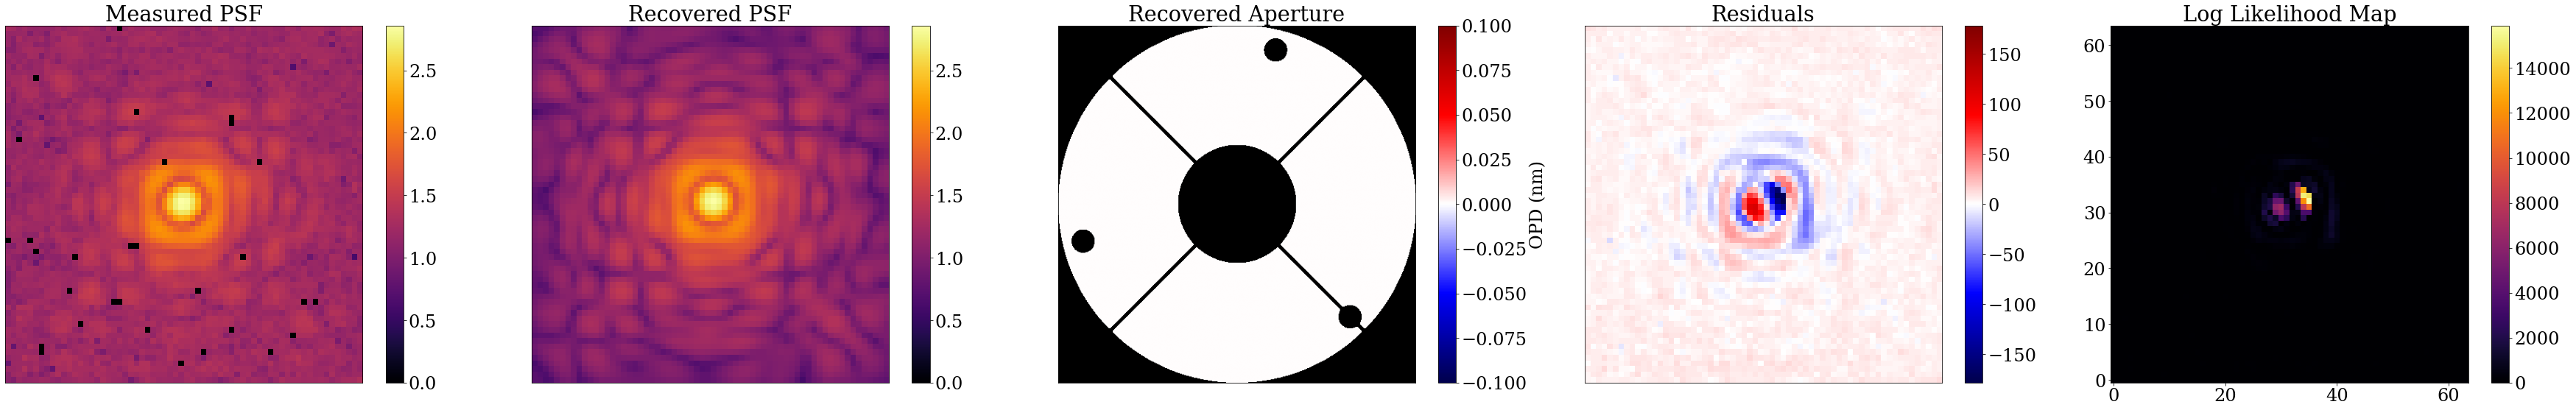

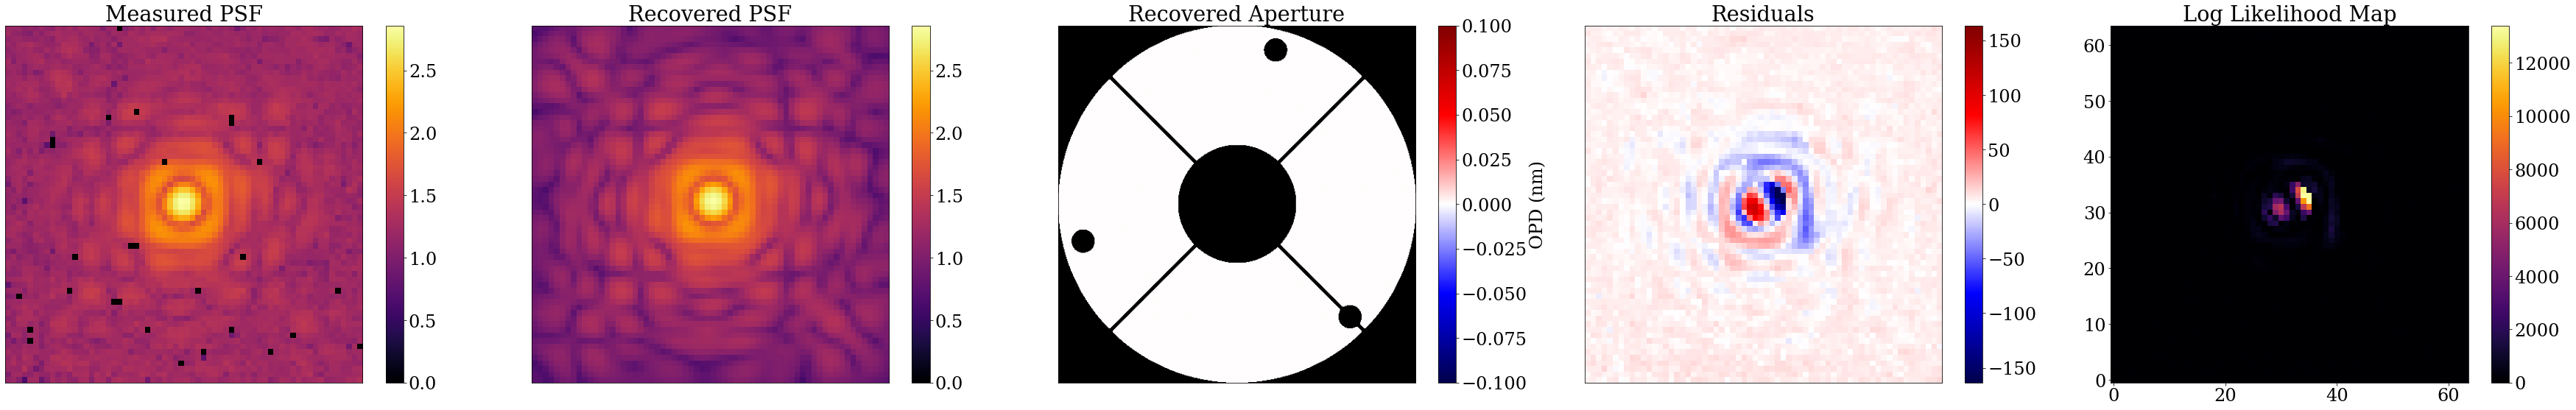

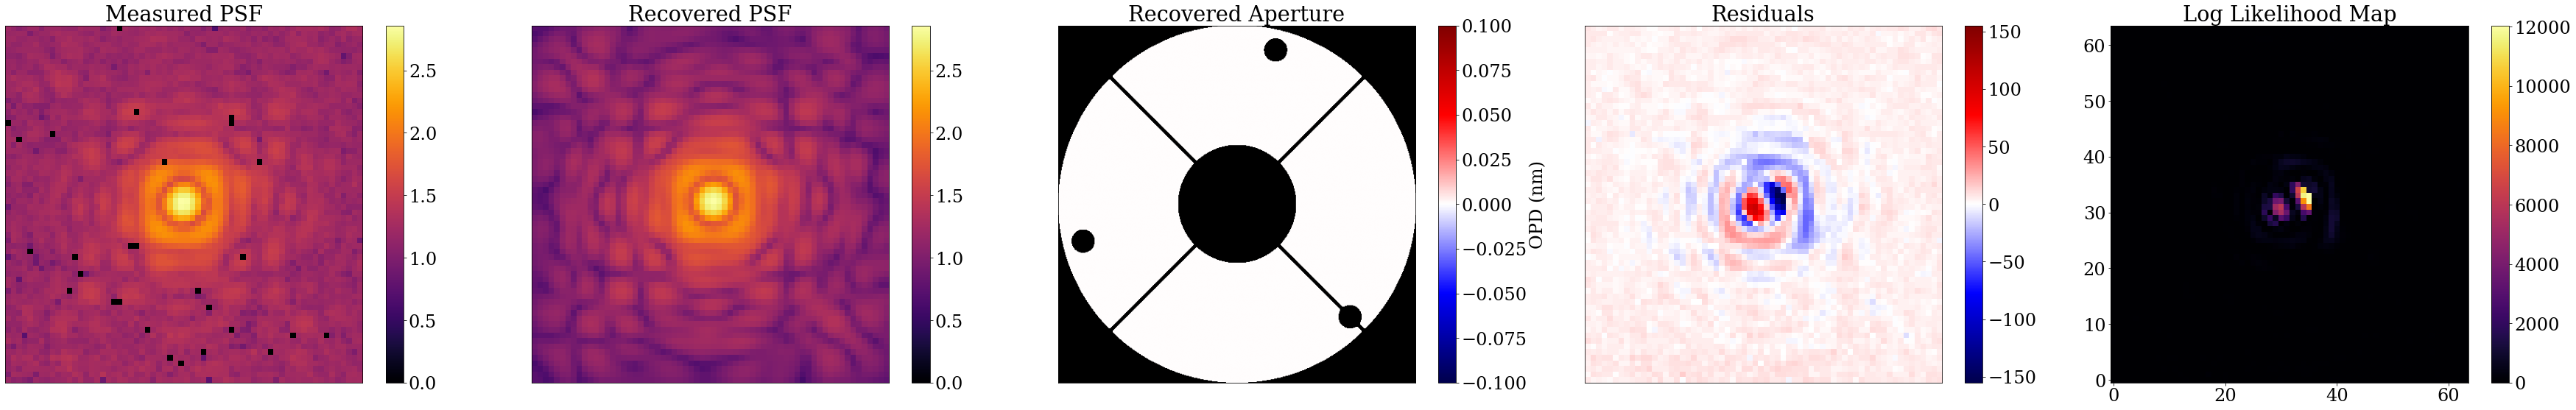

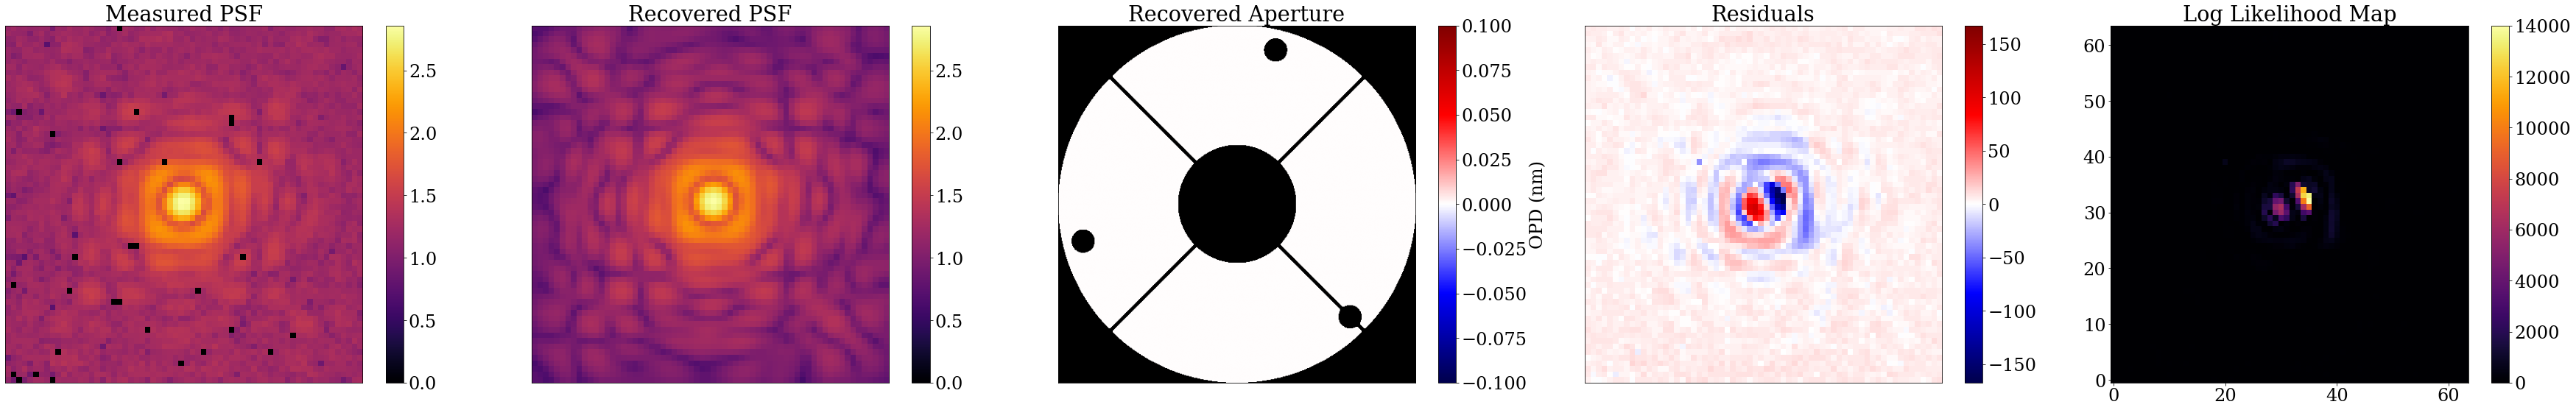

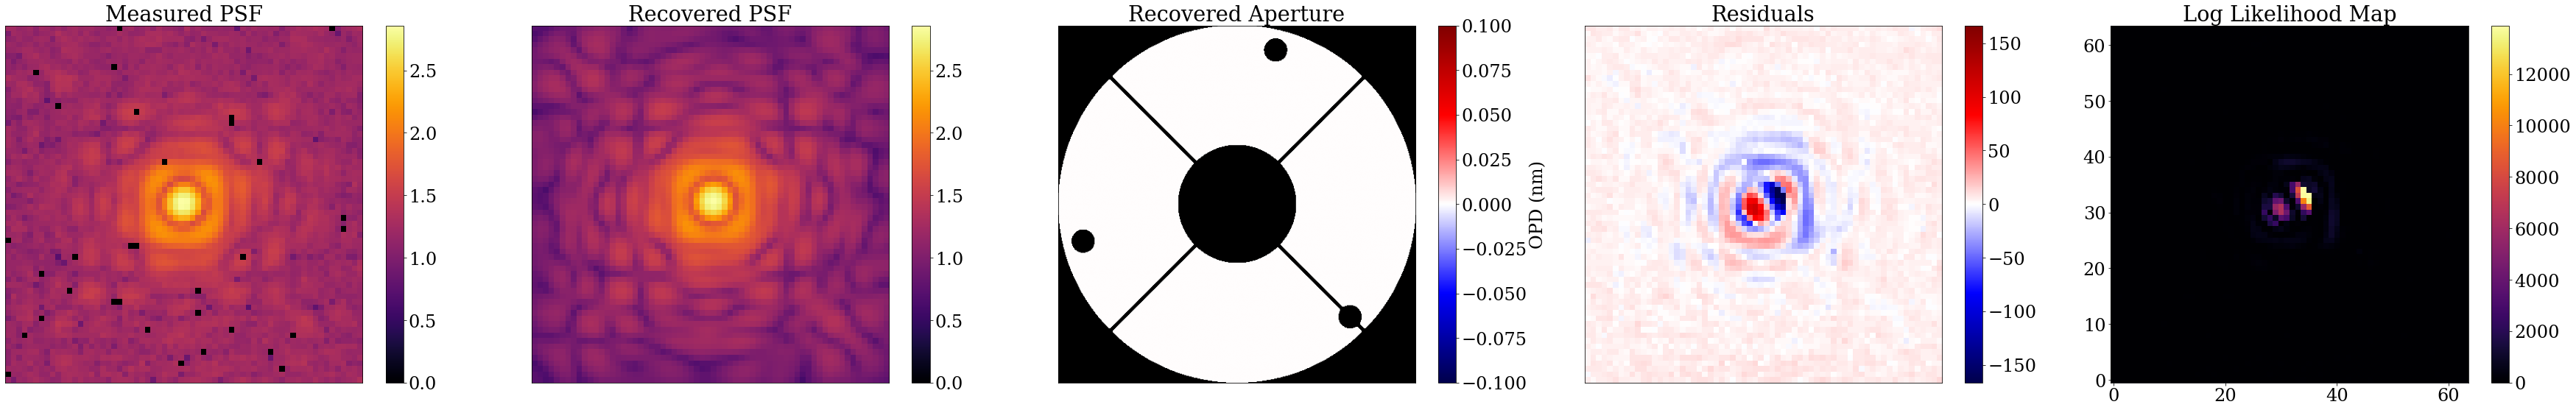

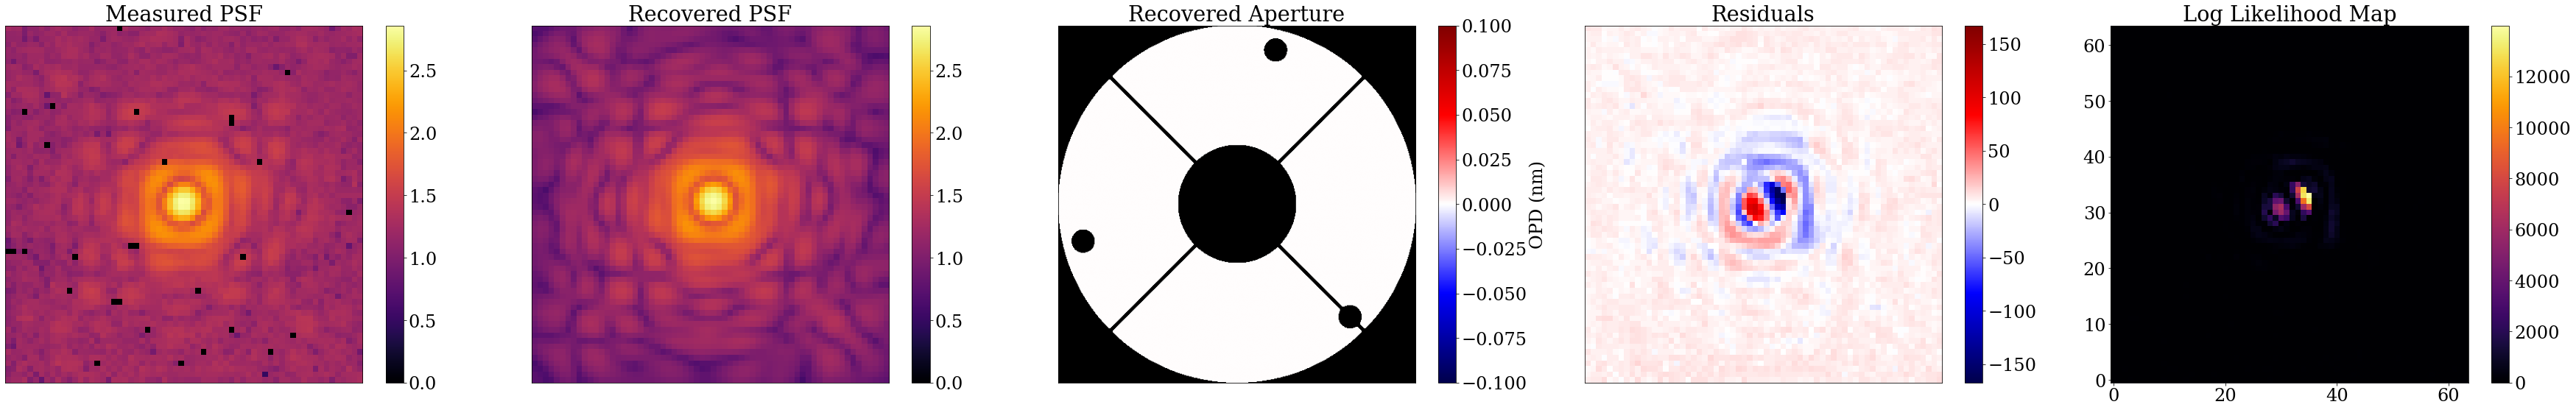

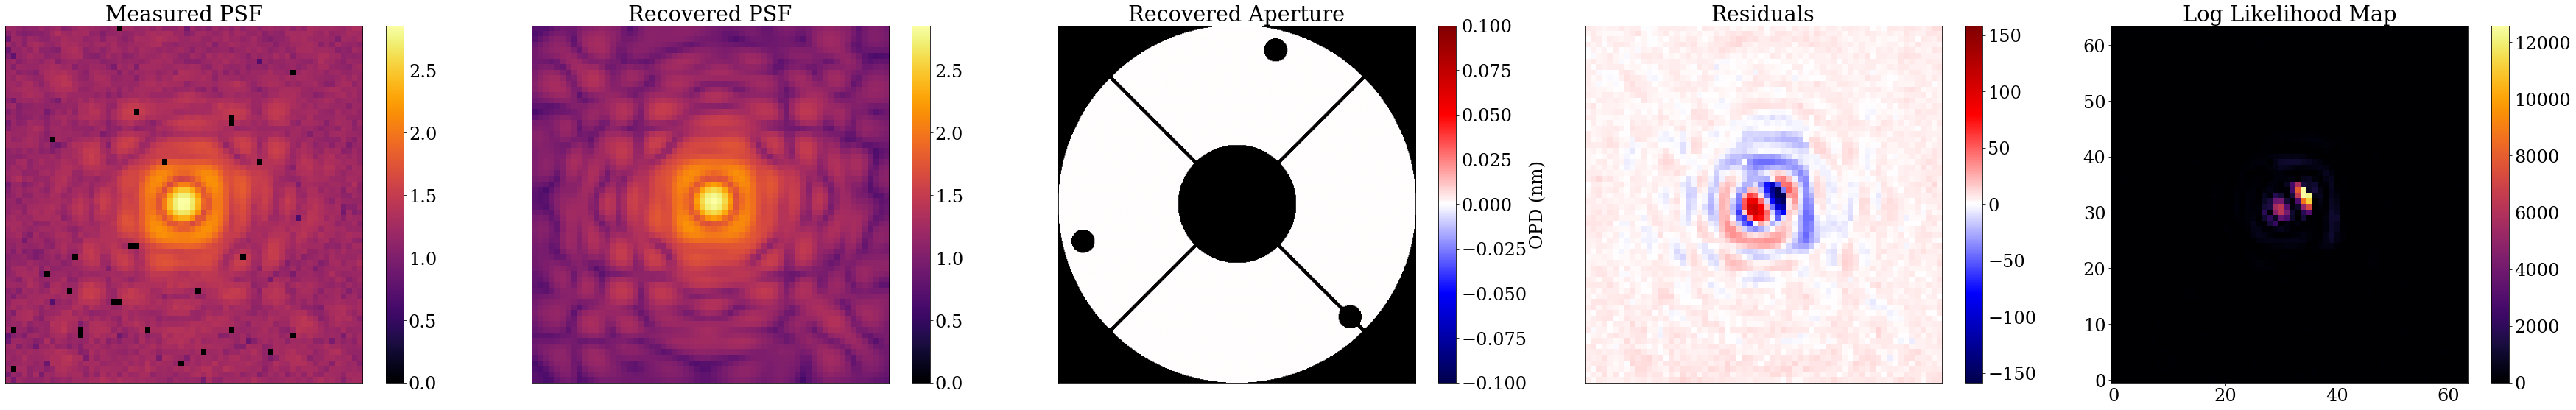

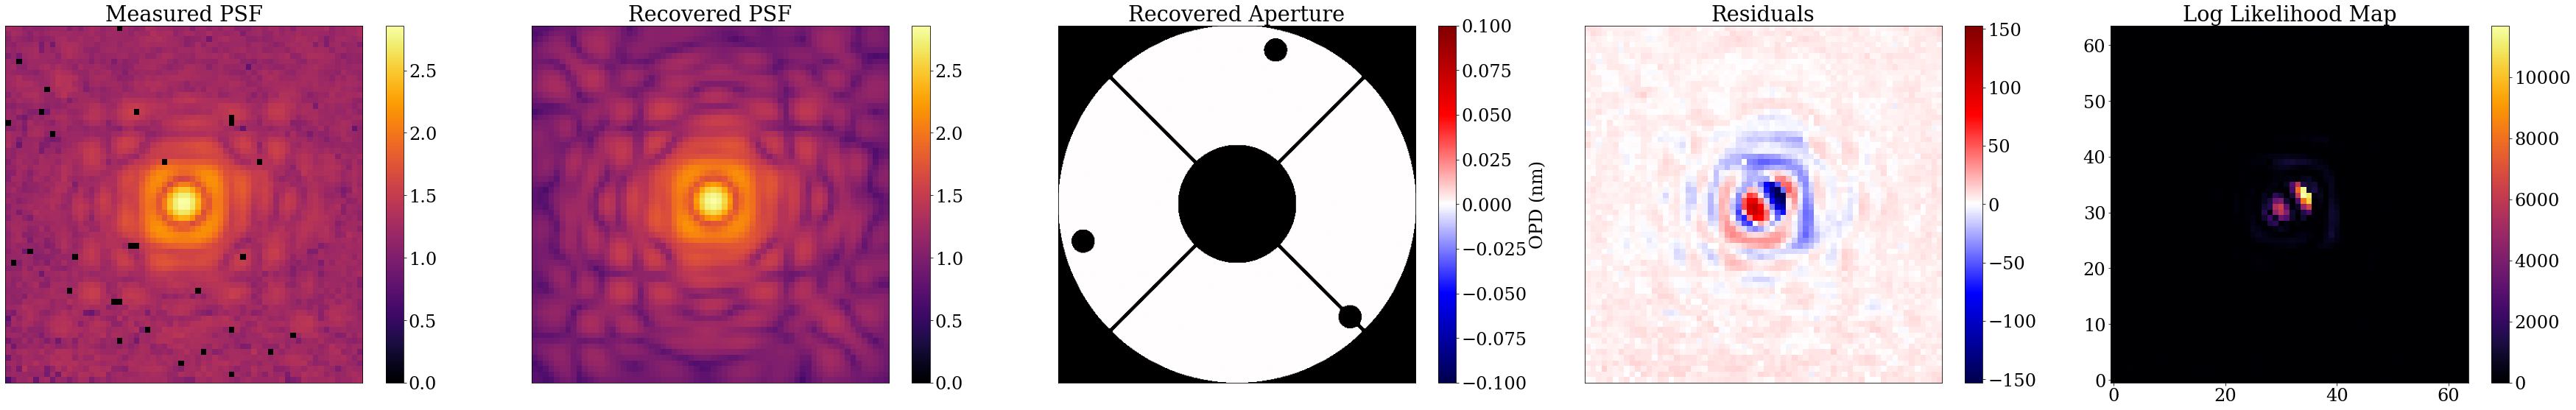

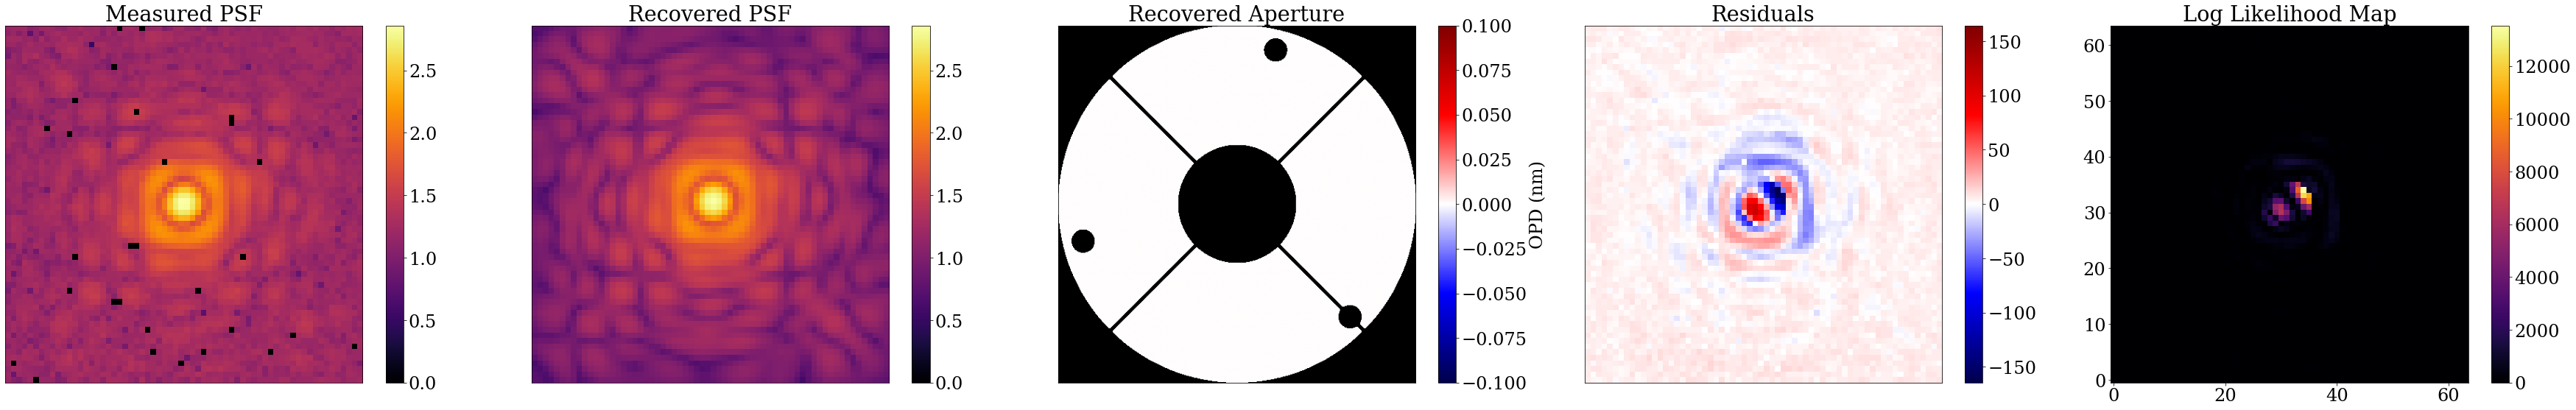

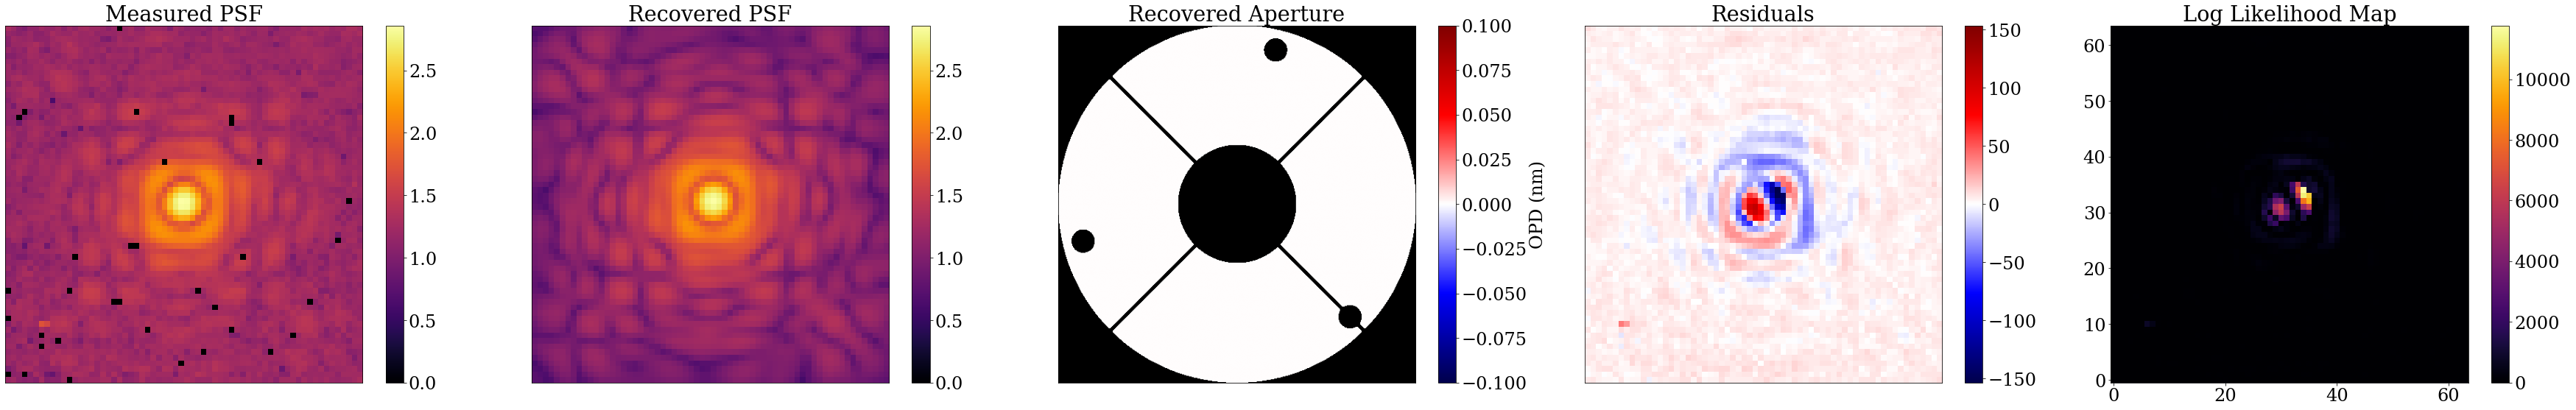

In [357]:
plot_comparison(model_single, params, exposures_single)

In [358]:
exposures_single[0].pam

-0.530879

In [359]:
exposures_single[0].bad[35,60]

Array(False, dtype=bool)

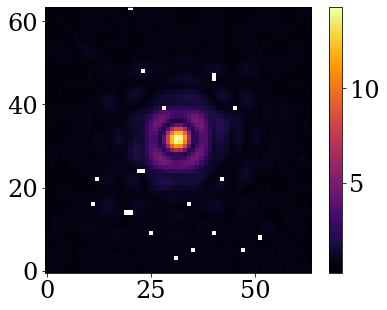

In [360]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

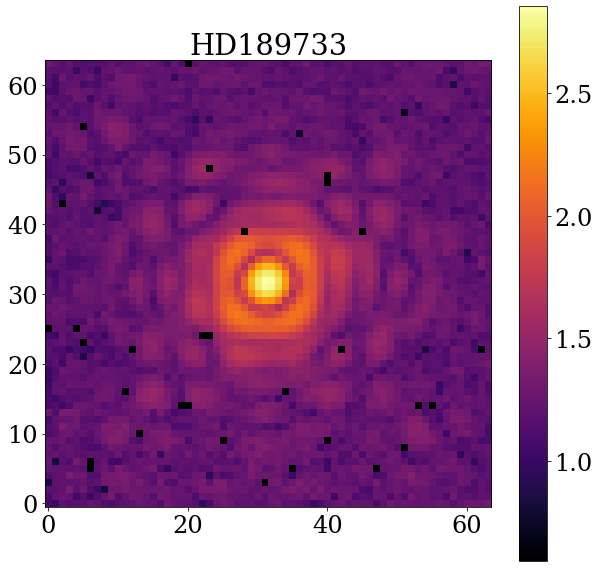

In [361]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [362]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [363]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 1e-2

things = {
    "positions": opt(g*2, 0),
    "spectrum": opt(g*8, 10),#, (20, 1.5)),
    #"cold_mask_shift": opt(g*100, 30),
    "cold_mask_shift": opt(g*10, 30),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*3, 20),
    #"aberrations": opt(g*0.15,300),#, (80, 2)),#, (150, g*0.2)),
    #"aberrations": opta(2, 50),
    "defocus": opt(g*2, 50),
    "aberrations": opta(2, 70),
    #"displacement": opt(g*30, 150),
}


groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [364]:
losses, models = optimise(params, model_single, exposures_single, things, 130)

Calculating Fishers


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/130 [00:00<?, ?it/s]

In [365]:
losses[-1]

Array(208532.25, dtype=float32)

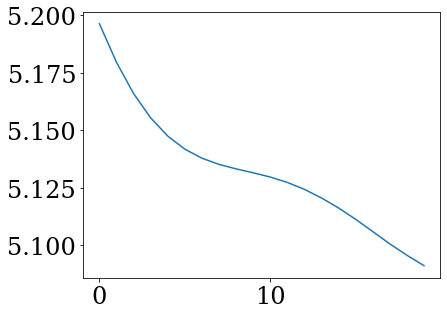

In [366]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

6


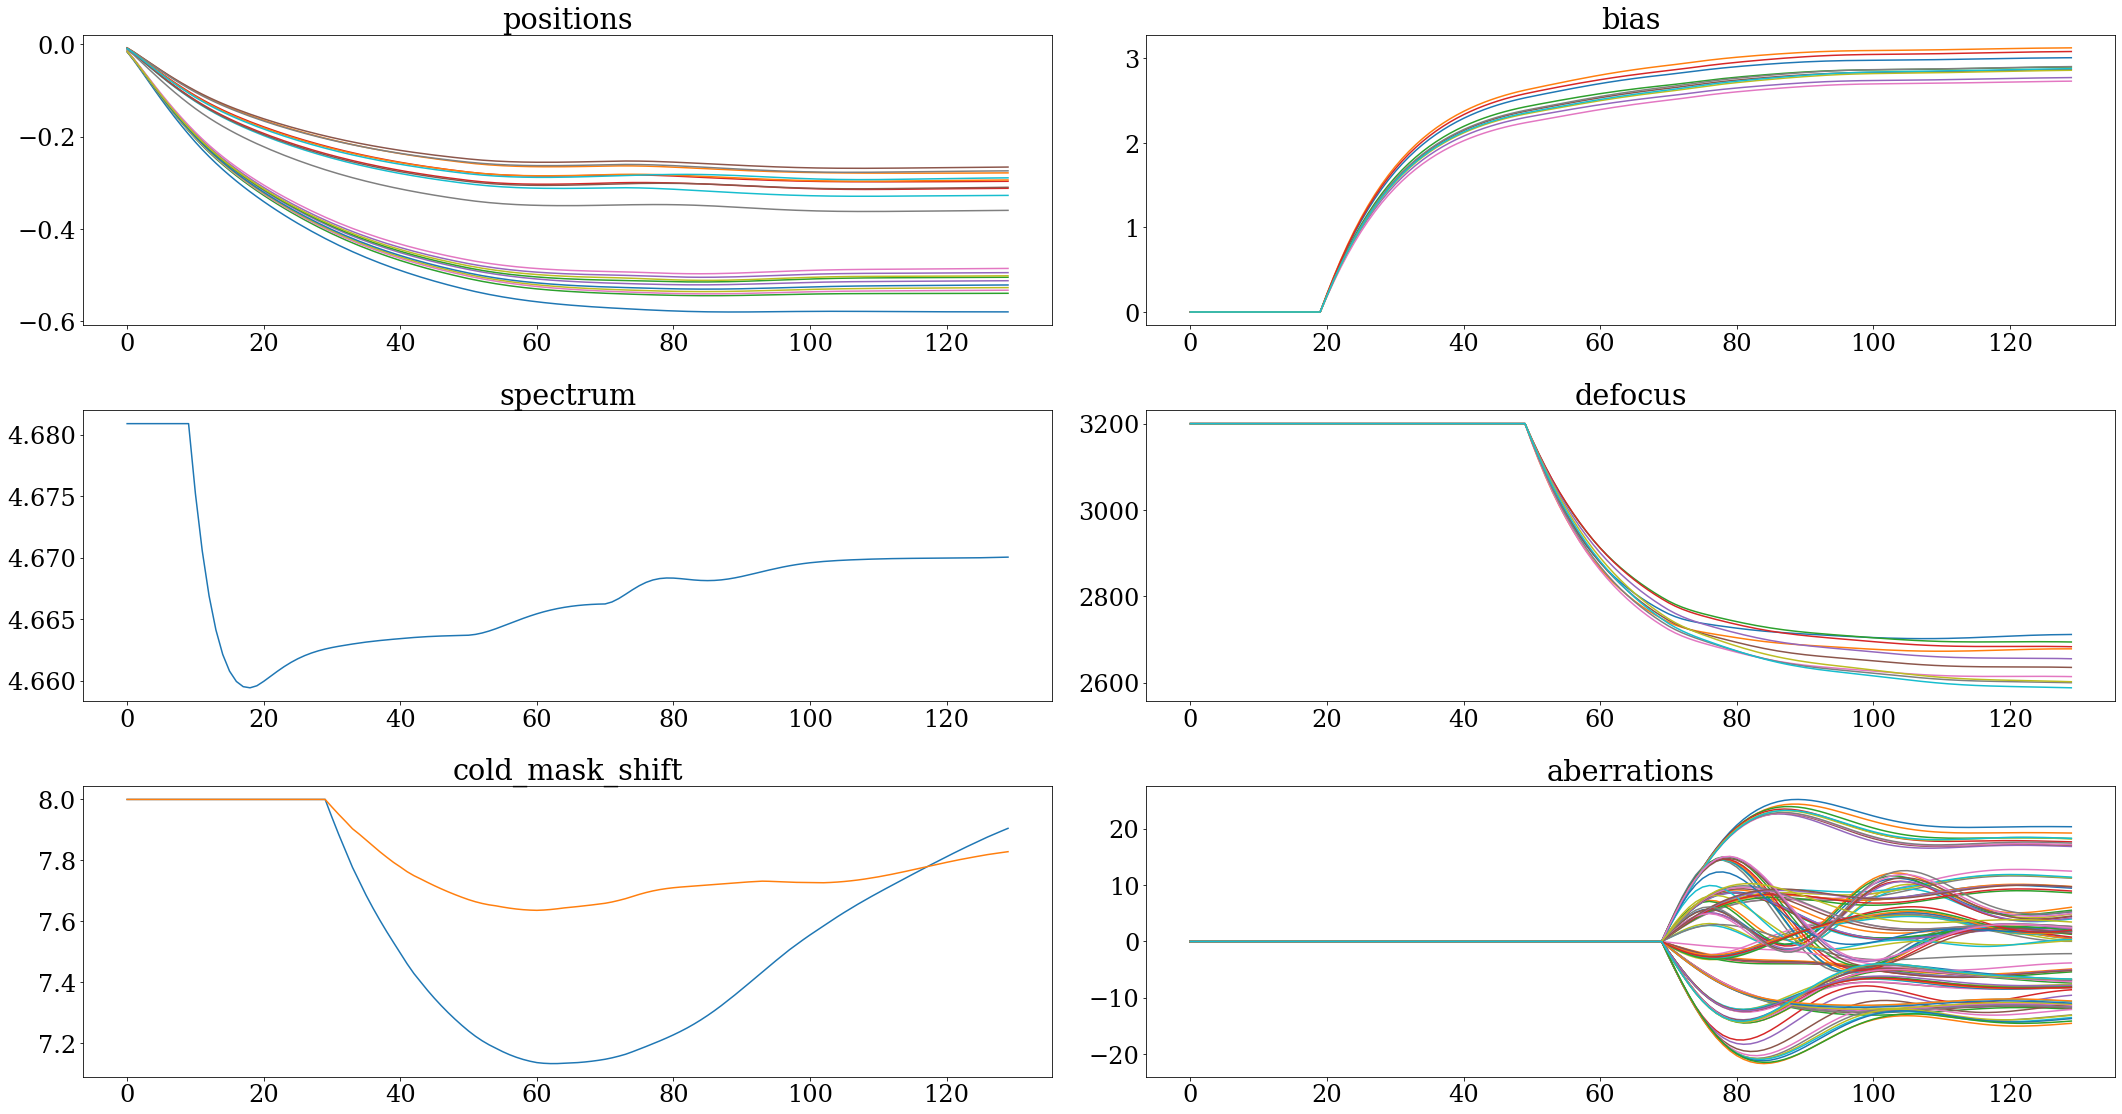

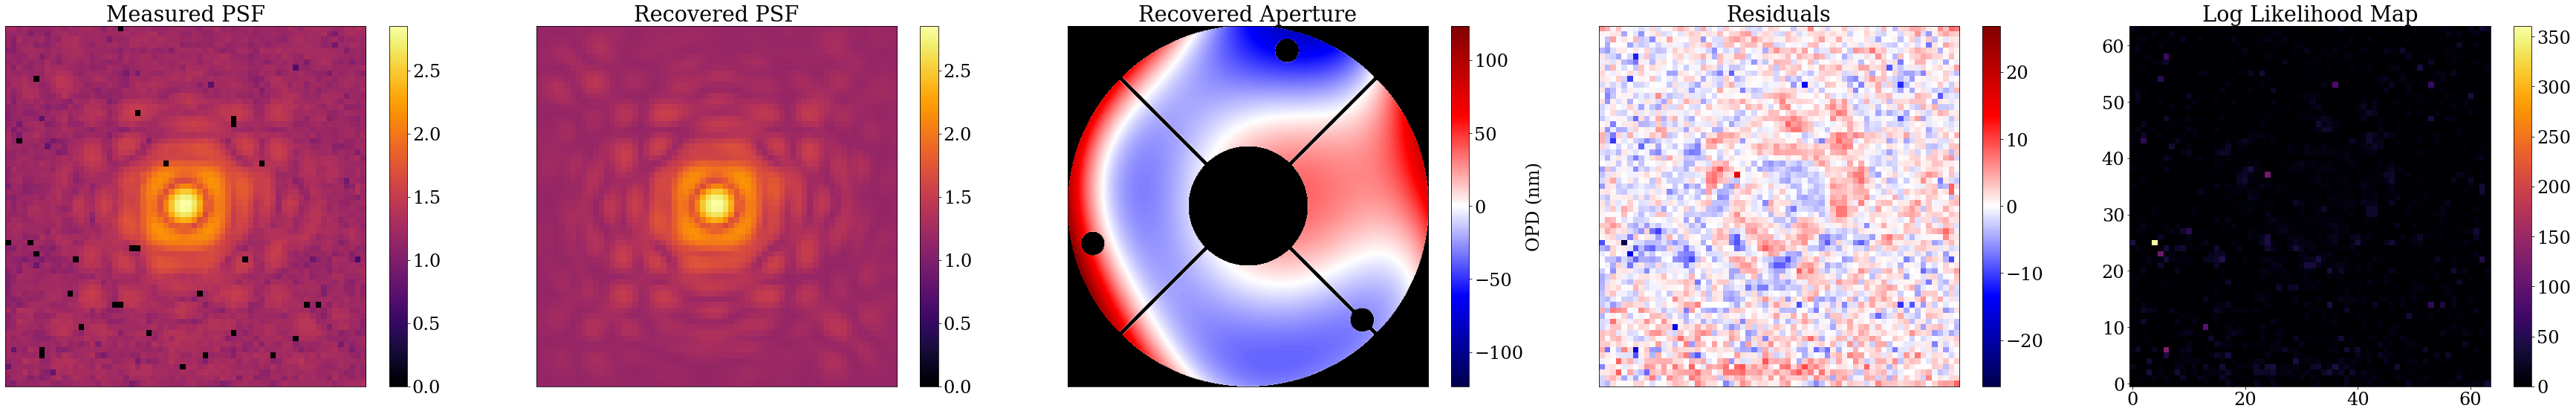

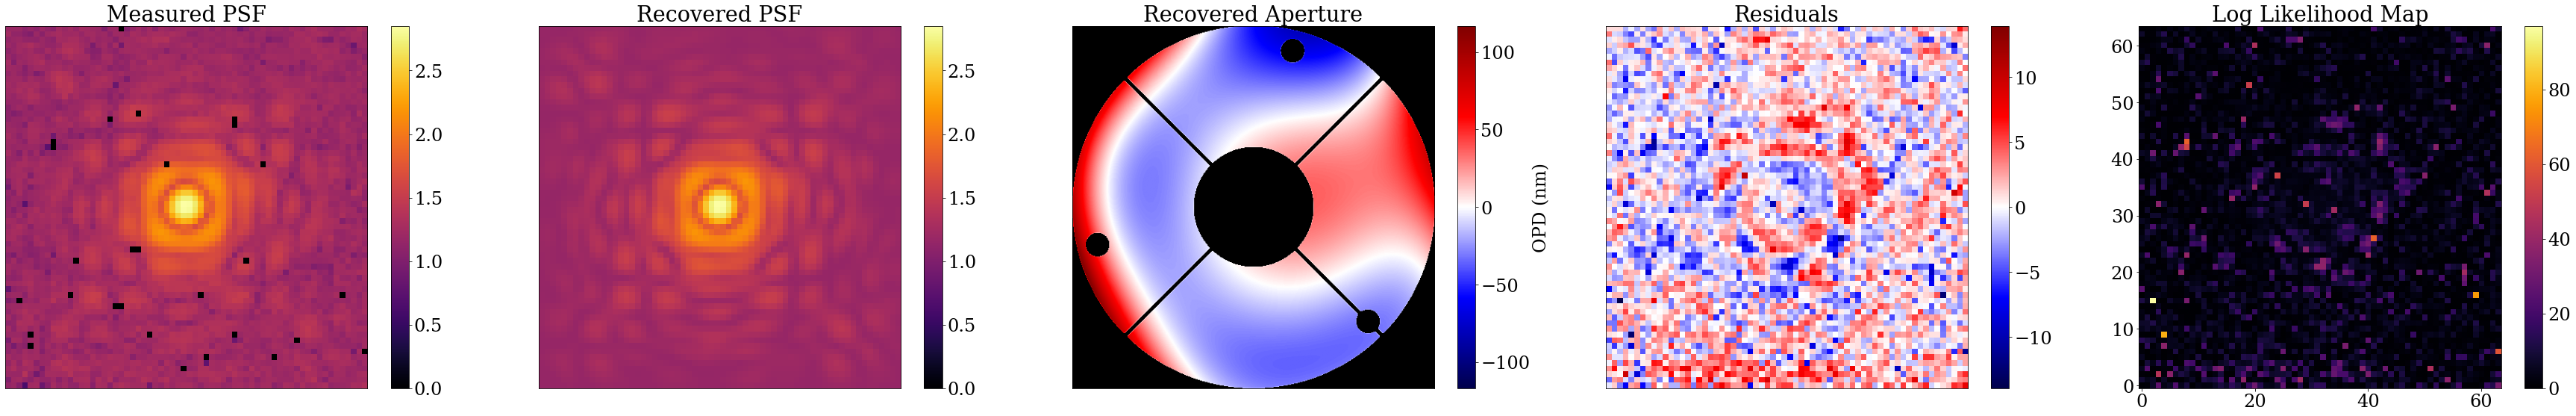

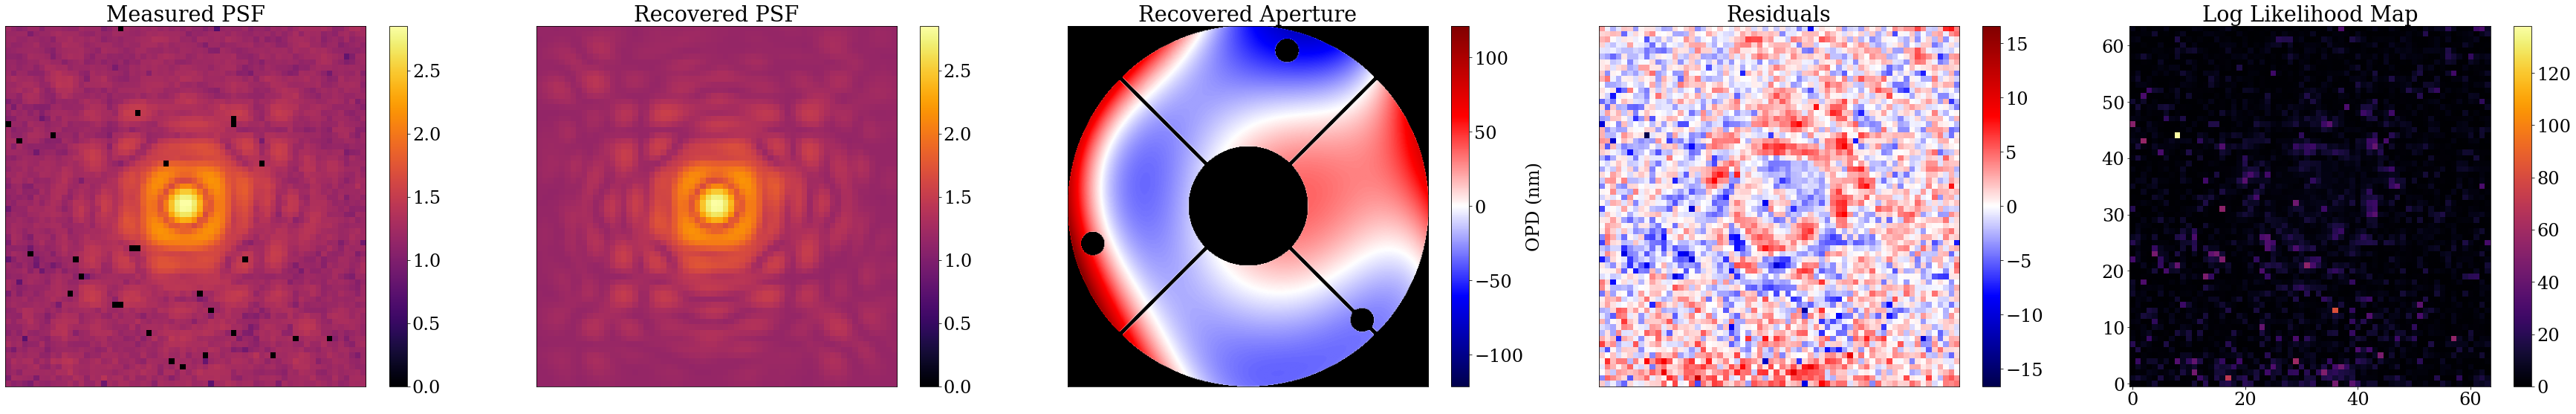

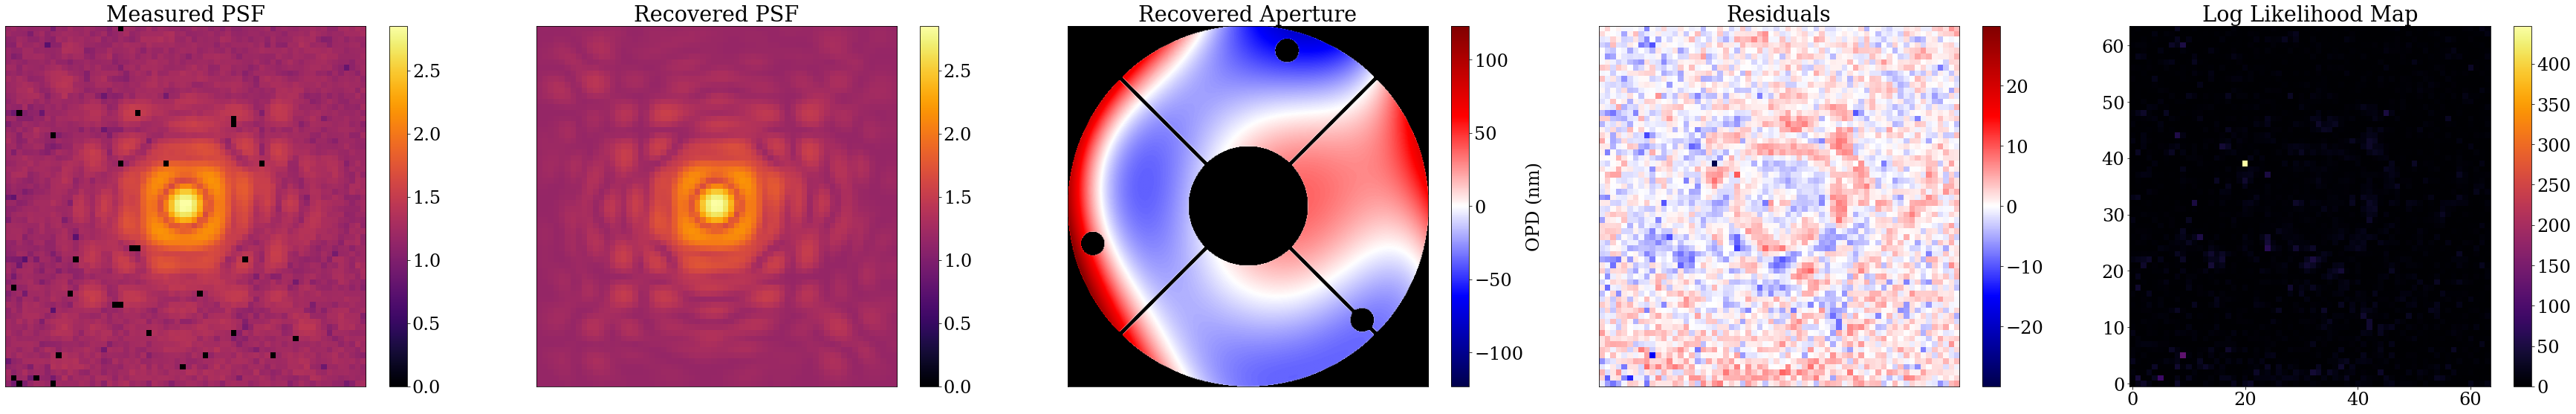

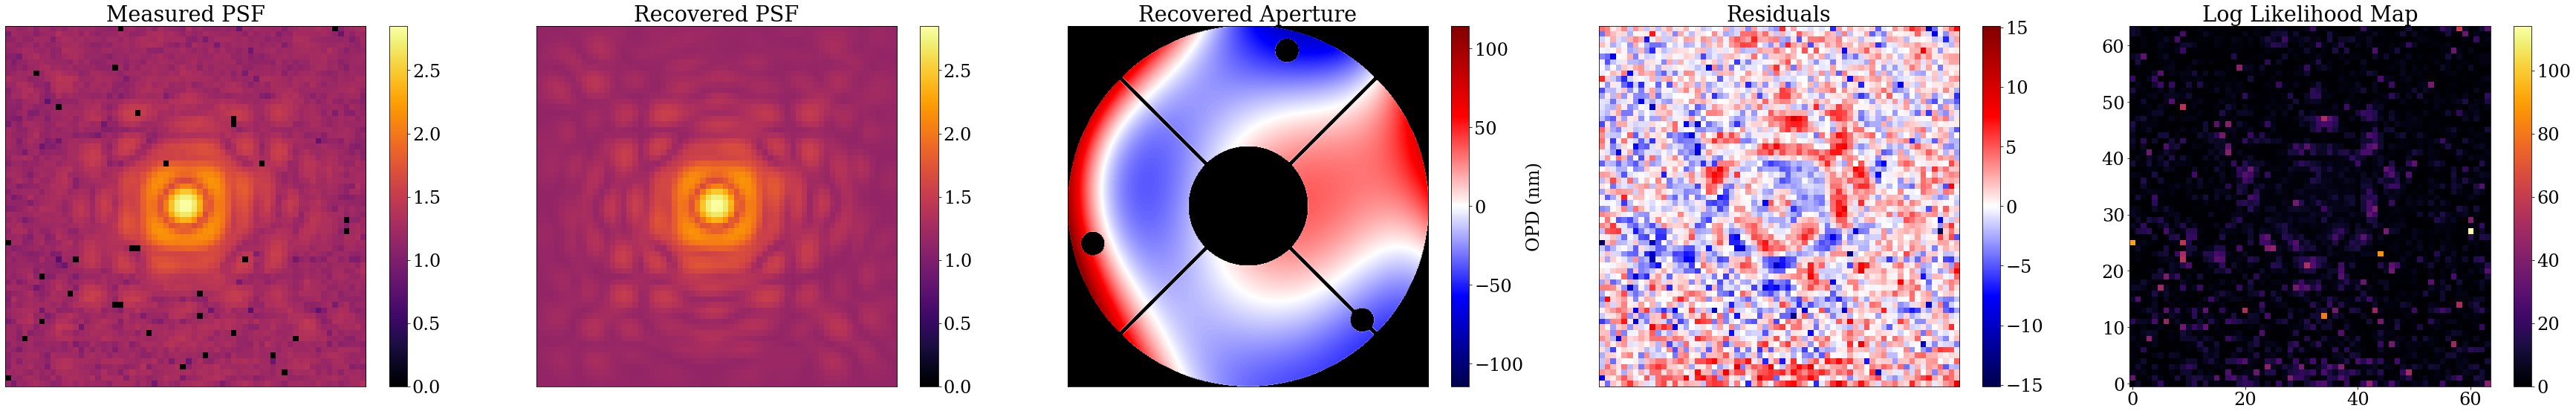

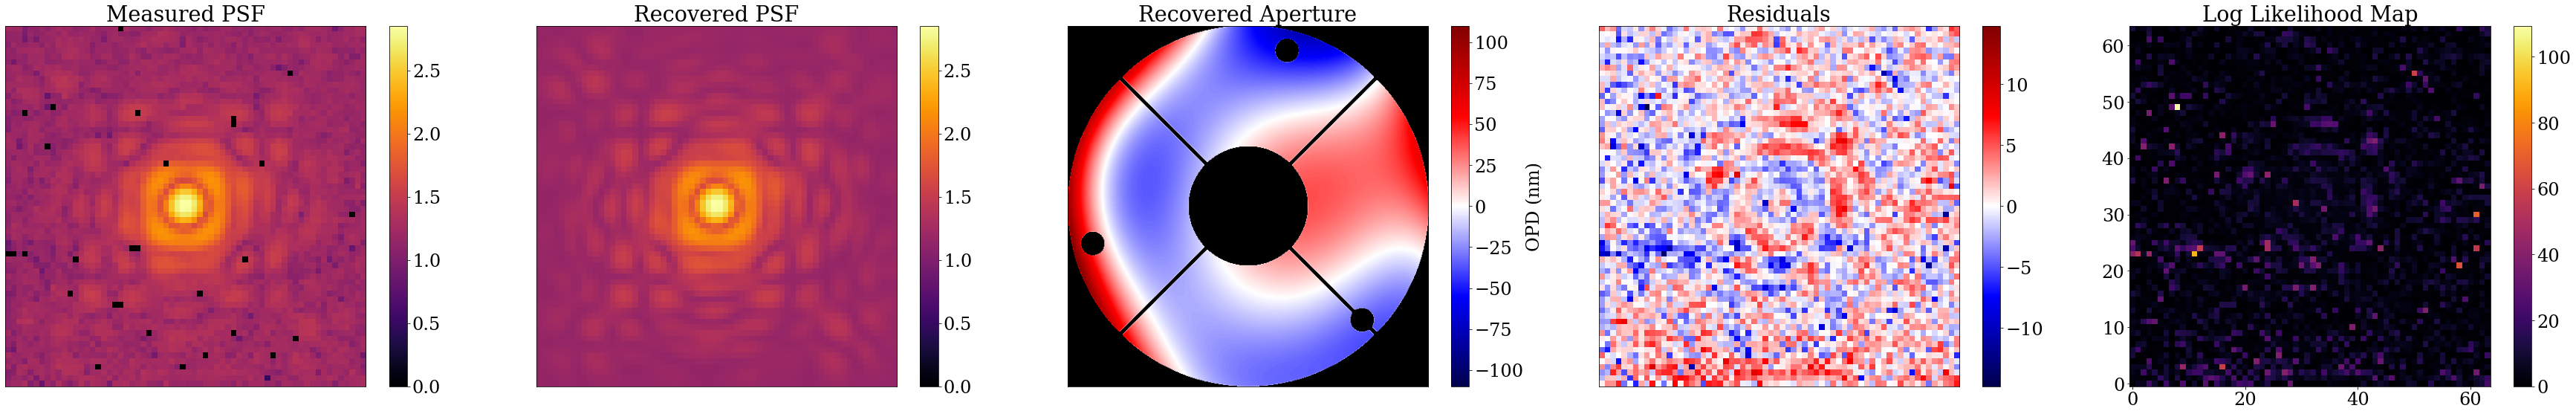

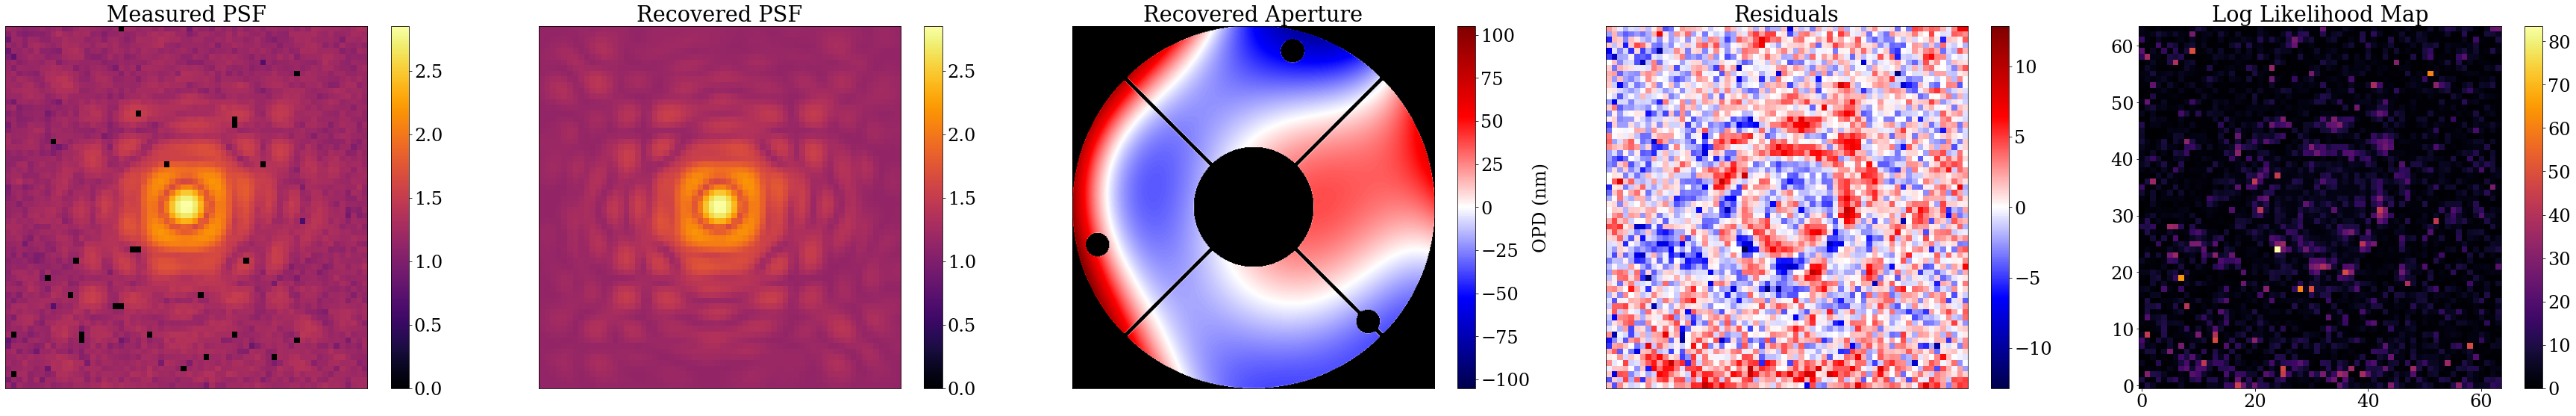

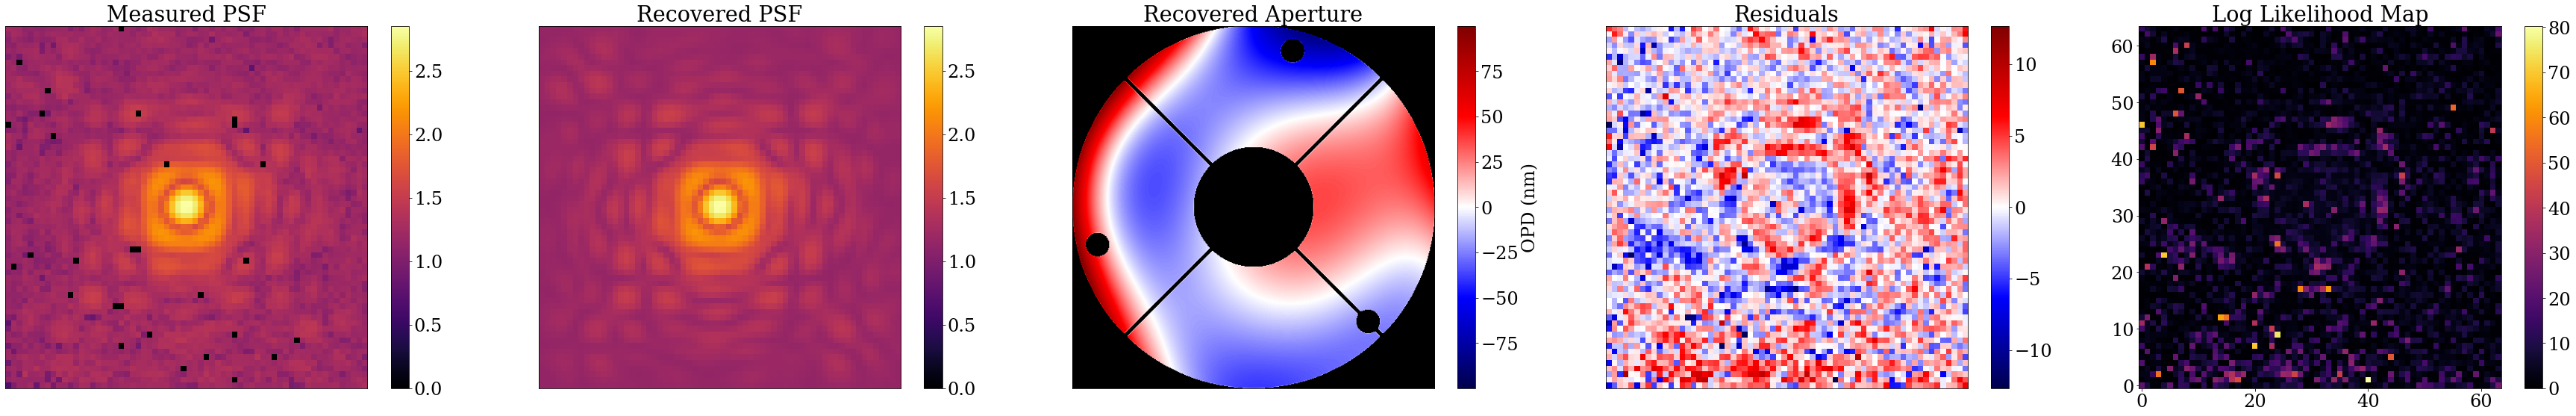

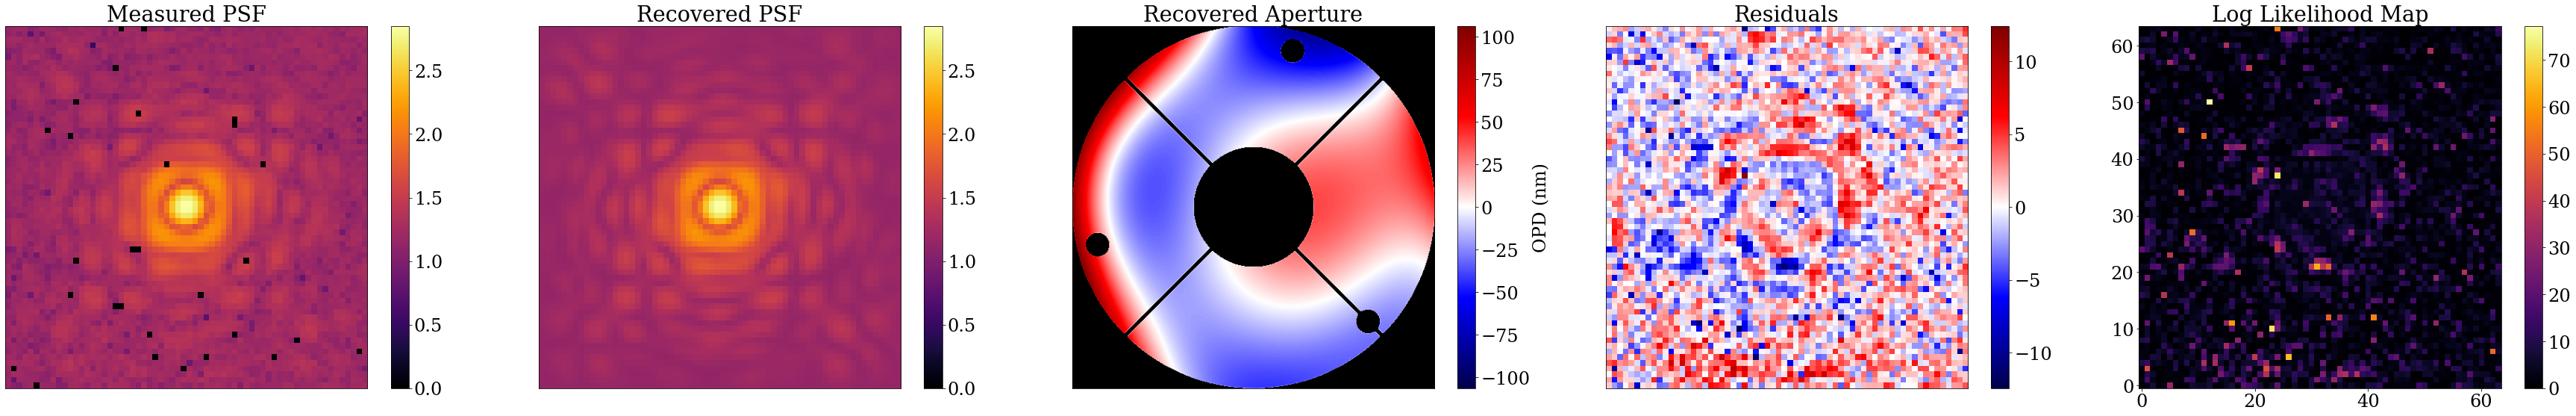

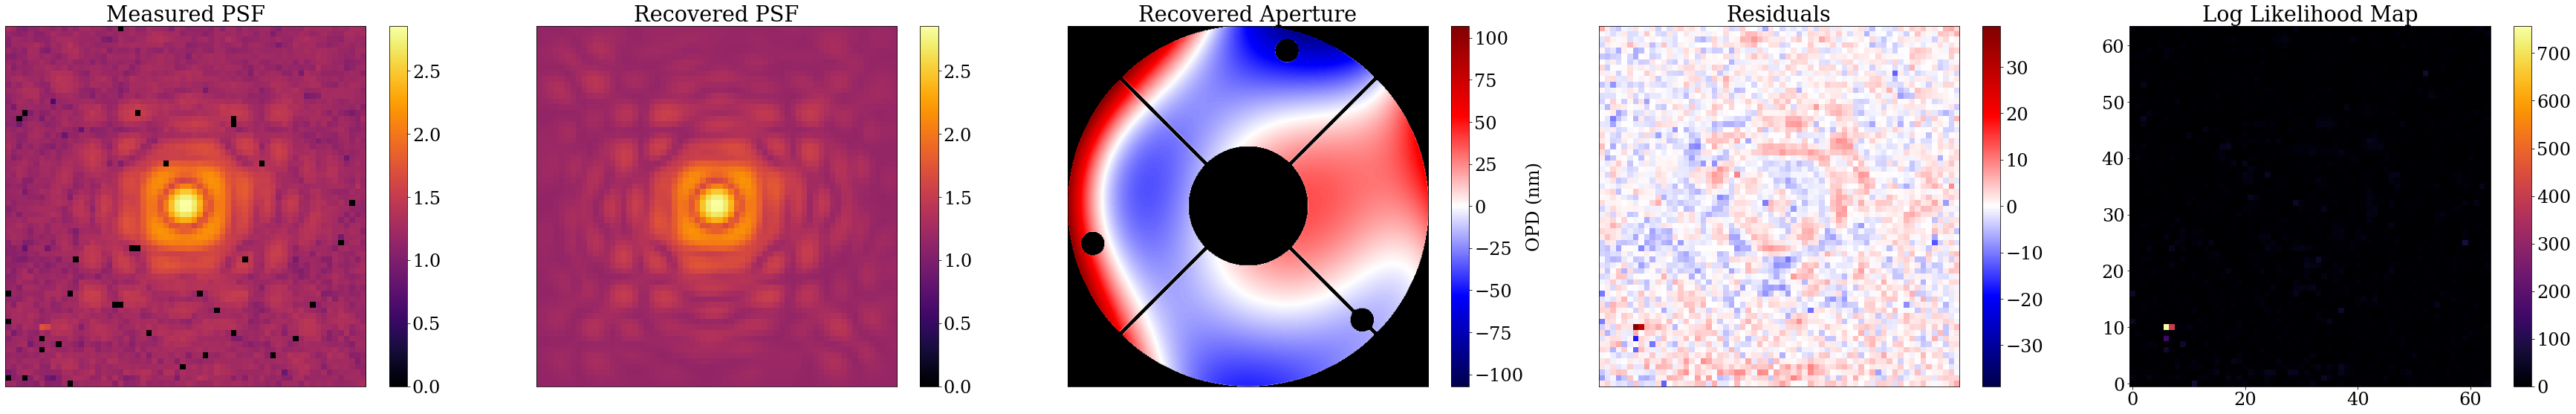

In [367]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [368]:
models[-1].params

{'aberrations': {'na2m01k7q': Array([ 20.375622  ,  -4.873954  , -12.016301  ,  -8.573324  ,
           2.6096563 ,  -7.917634  ,  12.489184  ,   0.02835655,
           4.8812513 ,   1.9416441 ,  -6.7586894 ], dtype=float32),
  'na2m01kiq': Array([ 19.253353  ,  -5.3989367 , -11.507455  ,  -9.548081  ,
           2.4240131 ,  -8.214275  ,  11.235326  ,   0.15981299,
           3.9906838 ,   2.1770313 ,  -7.01665   ], dtype=float32),
  'na2m01ksq': Array([ 18.29078   ,  -5.069539  , -11.56715   , -11.165329  ,
           2.5780885 ,  -7.7774744 ,  11.311188  ,   0.46779558,
           5.274388  ,   2.5520475 ,  -7.3682475 ], dtype=float32),
  'na2m01l3q': Array([ 17.691477 ,  -5.0626736, -11.822509 , -12.076484 ,   2.3315985,
          -7.6264043,  11.42704  ,   0.5826496,   6.0785265,   2.0692656,
          -7.030631 ], dtype=float32),
  'na2m01leq': Array([ 16.869936  ,  -5.186784  , -11.263813  , -13.037406  ,
           1.79379   ,  -8.0672455 ,   9.468702  ,   0.49281788,
         

In [369]:
fsh = calc_fishers(models[-1].inject(model_single), exposures_single, ["defocus"], recalculate=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [370]:
fsh2= calc_fishers(models[-1].inject(model_single), exposures_single, ["cold_mask_shift"], recalculate=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [371]:
defocuses = [x/20 for x in models[-1].params["defocus"].values()]
errs = [1/x['defocus']/20 for x in fsh.values()]
mjds = [exp.mjd for exp in exposures_single]
mjds= [(x - mjds[0])*24*60 for x in mjds]


In [372]:
np.asarray([x for x in models[-1].params["cold_mask_shift"].values()])

Array([[7.9051957, 7.8285832]], dtype=float32)

In [373]:
np.asarray([x for x in models[-1].params["spectrum"].values()])

Array([[4.6700606]], dtype=float32)

Text(0, 0.5, 'Defocus (nm)')

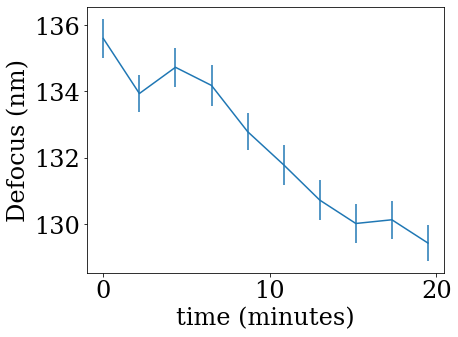

In [374]:
plt.errorbar(mjds, defocuses, np.squeeze(np.asarray(errs)))
plt.xlabel("time (minutes)")
plt.ylabel("Defocus (nm)")

In [375]:
abb = np.zeros((len(exposures_single), n_zernikes+1))
abb = abb.at[:,1:].set(np.asarray([x for x in models[-1].params["aberrations"].values()]))#.transpose()
abb = abb.at[:,0].set(np.asarray([float(x)/20 for x in models[-1].params["defocus"].values()]))
print(abb.shape)

pca = PCA(n_components=5)
pca.fit(abb)
print(pca.singular_values_)
print(pca.components_)
print(pca.explained_variance_)
components = pca.components_

(10, 12)
[12.413733   5.063208   2.7017546  1.2532303  1.10518  ]
[[-0.52811265 -0.12833351  0.62800574  0.10637511 -0.43493277 -0.06273855
  -0.00761174 -0.25244394  0.18229102 -0.01502161  0.08894673  0.02578686]
 [ 0.06993848  0.5479192   0.57235855  0.03076001  0.44289872  0.11582587
   0.02875783  0.3400456   0.07167193 -0.05044596  0.17712891  0.03554504]
 [ 0.33705398 -0.09136923  0.12871039 -0.03413009 -0.40864685  0.08733636
   0.19374853  0.38741454  0.1044178   0.6928419   0.08444663 -0.00158751]
 [ 0.15519032 -0.14946945 -0.01254832  0.2927441   0.07516988  0.2825162
   0.11139713 -0.2808559  -0.16840734 -0.00380767  0.6921966  -0.4283119 ]
 [ 0.03330611 -0.416169   -0.03058001  0.08318438  0.37543753 -0.03883664
   0.17429385  0.04043572  0.8012047  -0.02851558  0.01141896 -0.02217625]]
[17.122307    2.8484528   0.81105304  0.17450958  0.13571365]


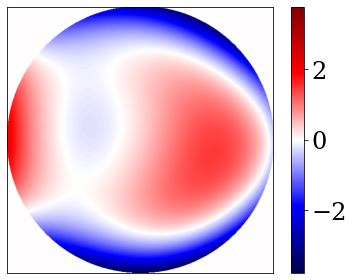

In [376]:
ap = dl.AberratedAperture(dl.CircularAperture(radius=1.2), noll_inds=np.arange(4,4+n_zernikes+1), coefficients=components[0])
coords = dlu.pixel_coords(512, 2.4)

opd = ap.eval_basis(coords)#*1e9
m = np.max(np.abs(opd))
plt.imshow(opd, cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.colorbar()
